In [1]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Pandas
import pandas as pd

### fitting
import statsmodels.api as sm

### PCA
from sklearn.decomposition import PCA, KernelPCA

### Model generation
import itertools as it

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable

# ### Yumi's RA/DEC ---> Magellanic Stream Coorindates
import MagellanicStream as ms

# ### Functions used in this code
import age_functions as afunc

### Stuff Writtten by A Really Cool Professor
import dlnpyutils as dlpu

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [2]:
###################
### Import Data ###
###################

# parsec
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/LMC_Ages/parsec3_3.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]


# r13
r13 = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/lmc_rgbmembers.r13-l33-58672.fits.gz')
cln = np.where((r13['FE_H']>-9999.0)&(r13['AK_TARG']>-100.0)&(r13['LOGG']>=0.0)&
                (r13['M_H_ERR']>-100.0)&(r13['C_FE']>-100.0)&(r13['N_FE']>-100.0))
r13 = r13[cln]

# APOKASC
kasc = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/APOKASC_cat_v6.6.1.fits.gz')

# Diane Feuillet
pdfout = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/LMC_DR16_all_PDF.fits.gz', 1)
_, r13_ind, pdfout_ind = np.intersect1d(r13['APOGEE_ID'],pdfout['OBJ'],return_indices=True)

In [3]:
###############################
### Some Calcuations Needed ###
###############################

### Convert RA DEC to MS L B
c_icrs = SkyCoord(ra=r13['RA']*u.degree, dec=r13['DEC']*u.degree)
c_ms = c_icrs.transform_to(ms.MagellanicStream)
ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

### Get Solar Fractions
abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))

<font size='48'>
    <b>
        Principal Component Analysis
    </b>
</font>

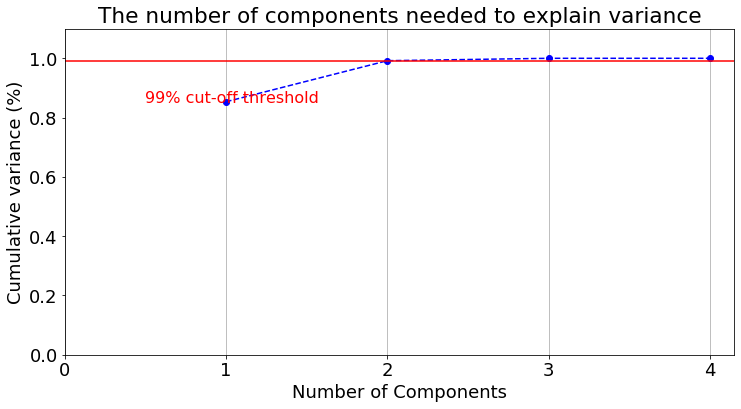

In [4]:
### Setup 
data = np.array([parsec['logTe'],parsec['Ksmag'],parsec['MH'],parsec['logg']]).T

### Determine Number of factors
pca = PCA(n_components=4).fit(data)#_rescaled)
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()

y = np.cumsum(pca.explained_variance_ratio_)
xi = np.arange(1, len(pca.explained_variance_ratio_)+1, step=1)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 5, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.99, color='r', linestyle='-')
plt.text(0.5, 0.85, '99% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

Cross 99% between 2 and 3 components so keep 3

<font size='48'>
    <b>
        Ordinary Least Squares
    </b>
</font>

In [6]:
### Find all models

#transform data to new basis
new_data = PCA(n_components=3).fit(data).transform(data)

#create new variables

# linear terms
x1 = new_data[:,0]
x2 = new_data[:,1]
x3 = new_data[:,2]

# linear int
x12 = np.multiply(x1,x2)
x13 = np.multiply(x1,x3)
x23 = np.multiply(x2,x3)

# squares
x1sq = x1**2
x2sq = x2**2
x3sq = x3**2

# cubes
x1cu = x1**3
x2cu = x2**3
x3cu = x3**3


#find all possible models
models = []
models_str = []

all_var_str = ['x1','x2','x3','x12','x13','x23','x1sq','x2sq','x3sq','x1cu','x2cu','x3cu']
all_var = [x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x1cu,x2cu,x3cu]

for i in range(1,len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))
        
models = np.array(models)
models_str = np.array(models_str)

### Fit All Models

import statsmodels.api as sm 

all_params = []
summaries = []
max_resid = []
mads = []
resids = []
predict = []
llf = [] 
for i in tqdm_notebook(range(len(models)),desc='Done?'):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logAge'],pmodl).fit()
    summaries.append(model.summary())
    predictions = model.predict(pmodl)
    predict.append(predictions)
    residual = predictions - parsec['logAge']
    resids.append(residual)
    all_params.append(np.asarray(model.params))
    max_resid.append(np.max(np.absolute(residual)))
    mads.append(afunc.mad(residual))
    llf.append(model.llf)

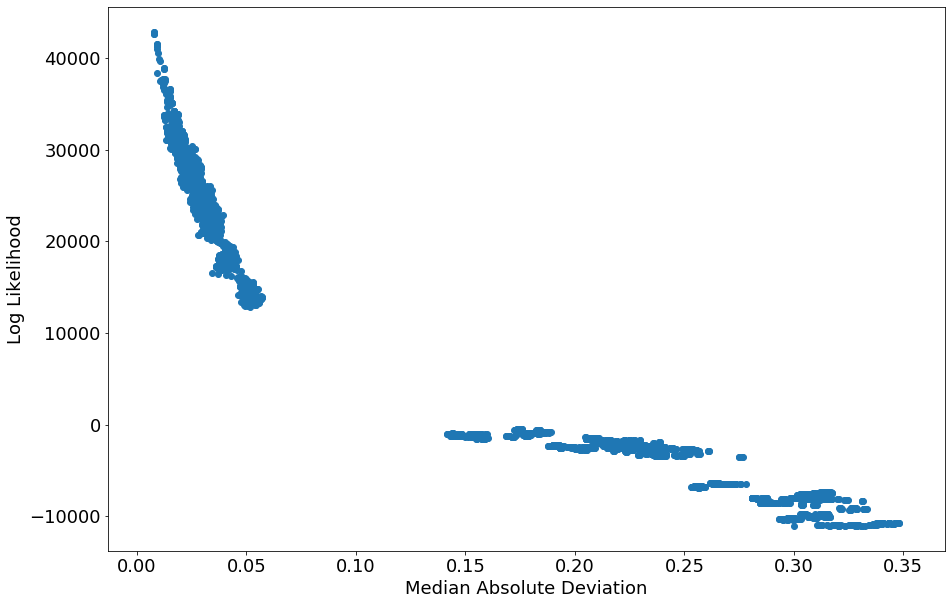

In [11]:
plt.figure(figsize=[15,10])
plt.scatter(mads,llf)
plt.xlabel('Median Absolute Deviation')
plt.ylabel('Log Likelihood')
plt.show()

In [29]:
print(models_str[np.asarray(llf).argmax()])
print(all_params[np.asarray(llf).argmax()])

['x1' 'x2' 'x3' 'x12' 'x13' 'x23' 'x1sq' 'x2sq' 'x3sq' 'x1cu' 'x2cu'
 'x3cu']
[ 9.38632004e+00  4.56560132e-02 -5.98144381e-02 -2.99645418e+00
  1.86773433e-02 -4.49811350e-02  1.10821907e-01 -5.93635093e-03
  2.51466115e-02  7.98516719e-01  6.91983807e-06  2.26647606e-02
  4.02013915e-01]
(array([], dtype=int64),)


In [30]:
parsimonious = np.array([x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x2cu,x3cu]).T
parsimonious = sm.add_constant(parsimonious)
parsimonious_model = sm.OLS(parsec['logAge'],parsimonious).fit()
parsimonious_predictions = parsimonious_model.predict(parsimonious)
parsimonious_residual = parsimonious_predictions - parsec['logAge']
parsimonious_summary = parsimonious_model.summary()
print(parsimonious_summary)
print('MAD: ',afunc.mad(parsimonious_residual))
print('x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x2cu,x3cu')
print(np.asarray(parsimonious_model.params))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.846e+06
Date:                Tue, 28 Jul 2020   Prob (F-statistic):               0.00
Time:                        15:17:03   Log-Likelihood:                 42862.
No. Observations:               14946   AIC:                        -8.570e+04
Df Residuals:                   14934   BIC:                        -8.561e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3863      0.000   4.15e+04      0.0

In [31]:
[ 9.38631710e+00,4.57009017e-02,-5.98198867e-02,-2.99642242e+00,
1.86921027e-02,-4.51165023e-02,1.10829968e-01,-5.93377185e-03,
2.51457473e-02,7.98522275e-01,2.26643514e-02,4.00941011e-01] == [ 9.38631710e+00,4.57009017e-02,-5.98198867e-02,
                                                                 -2.99642242e+00,1.86921027e-02,-4.51165023e-02,
                                                                 1.10829968e-01,-5.93377185e-03,2.51457473e-02,
                                                                 7.98522275e-01,2.26643514e-02,4.00941011e-01]

True

<font size='48'>
    <b>
        Calculate Ages
    </b>
</font>

In [49]:
def find_ages(z1,z2,z3):
    p = [9.38631710e+00,  4.57009017e-02, -5.98198867e-02, -2.99642242e+00,
  1.86921027e-02, -4.51165023e-02,  1.10829968e-01, -5.93377185e-03,
  2.51457473e-02,  7.98522275e-01,  2.26643514e-02,  4.00941011e-01]
    age = (p[0] + 
           p[1]*z1 + p[2]*z2 + p[3]*z3 +
           p[4]*np.multiply(z1,z2) + p[5]*np.multiply(z1,z3) + p[6]*np.multiply(z2,z3) +
           p[7]*(z1**2) + p[8]*(z2**2) + p[9]*(z3**2) +
           p[10]*(z2**3) + p[11]*(z3**3))
    return age

In [42]:
### Uncertainty Functions

def add_noise(quant,quant_err,distribution='normal'):
    '''
    Add noise to data and return new values
    
    Parameters:
    ----------
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
        distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
    return: 
    ------
        1d array-like object of data with added noise
    
    '''
    if distribution == 'normal':
        return np.random.normal(quant,quant_err)
    if distribution == 'poisson':
        return quant + np.random.poisson(quant_err)
    if distribution == 'uniform':
        return np.random.uniform(-quant_err+quant,quant+quant_err)

def sal_noise(cfe,cfeERR,nfe,nfeERR,feh,fehERR,mh,mhERR):
    '''
    Calculate noisy values for Salaris calculation with C and N.
    This does not take into account actually plugging in [M/H],
    for that use add_noise.
    
    Parameters:
        cfe: 1d array-like object of carbon abundances
        cfeERR: 1d array-like object of carbon abundance errors
        nfe: 1d array-like object of nitrogen abundances
        nfeERR: 1d array-like object of nitrogen abundance errors
        feh: 1d array-like object of iron abundances
        fehERR: 1d array-like object of iron abundance errors
        
    Return:
        noisy Salaris correction ffac
    '''
    
    sol_C = 0.28115244582676185 #solar carbon abundance
    sol_N = 0.06901474154376043 #solar nitrogen abundance
    
    # Calculate [C/M] and [N/M] with respective errors
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    
    # Calculate X fractions for C and N with respective errors
    x_C = sol_C*10**(cm)
    x_N = sol_N*10**(nm)
    
    x_CERR = 10**(cm)*np.log(10)*CMERR
    x_NERR = 10**(nm)*np.log(10)*NMERR
    
    # Calcuate f factor in Salaris correction with respective errors
    ffac = (x_C+x_N)/(sol_C+sol_N) #factor from Salaris correction
    ffacERR = np.sqrt((x_CERR)**2+(x_NERR)**2)/(sol_C+sol_N)
    
    # Add noise to calculated f factor
    ffacnoise = np.random.uniform(-np.absolute(0.434*(ffacERR/ffac)),np.absolute(0.434*(ffacERR/ffac))) 
    
    return ffac + ffacnoise

In [50]:
### Age Distributions No Offsets

age_dist = []

pca_transform = PCA(n_components=3).fit(data)

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(500):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
        
#         if feh <= halo_cutoff:
#             dist_new = add_noise(dist,1.0,distribution='uniform')
#             absK_new = afunc.absmag(ks_new,dist_new) - ak
        
#         else:
#             absK_new = afunc.absmag(ks_new,dist) - ak
            
        absK_new = afunc.absmag(ks_new,dist) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,ffac_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))

    for l in range(len(zs)):
        noise_ages.append(find_ages(zs[l][0],zs[l][1],zs[l][2]))
    
    age_dist.append(noise_ages)

parages = [] 
devs = []
for k in range(len(age_dist)):
    devs.append(afunc.mad(age_dist[k]))
    parages.append(np.median(age_dist[k]))

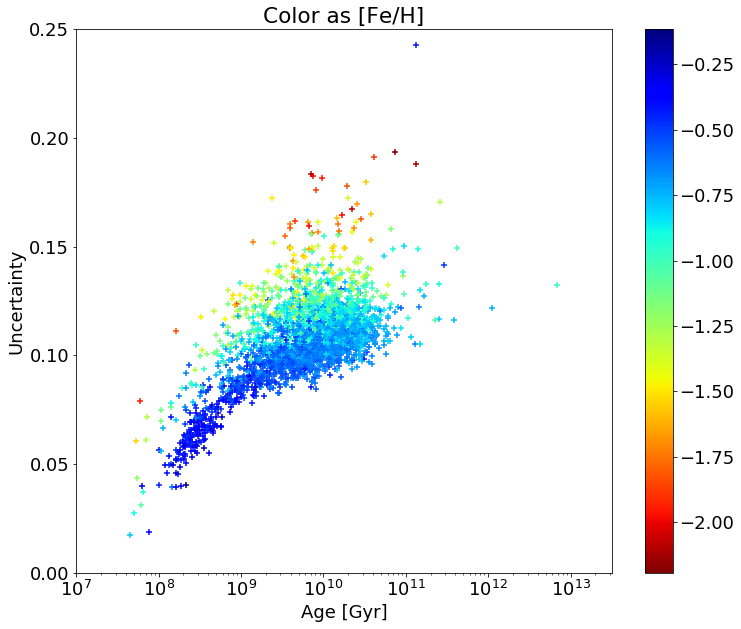

In [51]:
### Plot Uncertainties as Function of Age 

plt.figure(figsize=[12,10])

plt.title(r'Color as [Fe/H]')
plt.xlabel(r'Age [Gyr]')
plt.ylabel(r'Uncertainty')

plt.xscale('log')

plt.xlim(10**7,10**13.5)
plt.ylim(0,0.25)

plt.scatter(10**np.asarray(parages),np.asarray(devs),marker='+',c=r13['FE_H'],cmap='jet_r',label='No Offset')
plt.colorbar()

plt.show()

In [52]:
len(np.squeeze(np.where(parages<=np.log10(0.5*10**9))))

200

In [53]:
### Create fits file of ages (no distance offset)
cat = Table()
col_id = Column(np.asarray(r13['APOGEE_ID']),name='APOGEE_ID')
col_age = Column(np.asarray(parages),name='AGE')
col_dev = Column(np.asarray(devs),name='AGE_ERR')
col_dist = Column(np.asarray(age_dist),name='DIST')

cat.add_column(col_id)
cat.add_column(col_age)
cat.add_column(col_dev)
cat.add_column(col_dist)

cat.write('pca_ols_ages.fits',format='fits',overwrite=True)

Text(0, 0.5, 'y (kpc)')

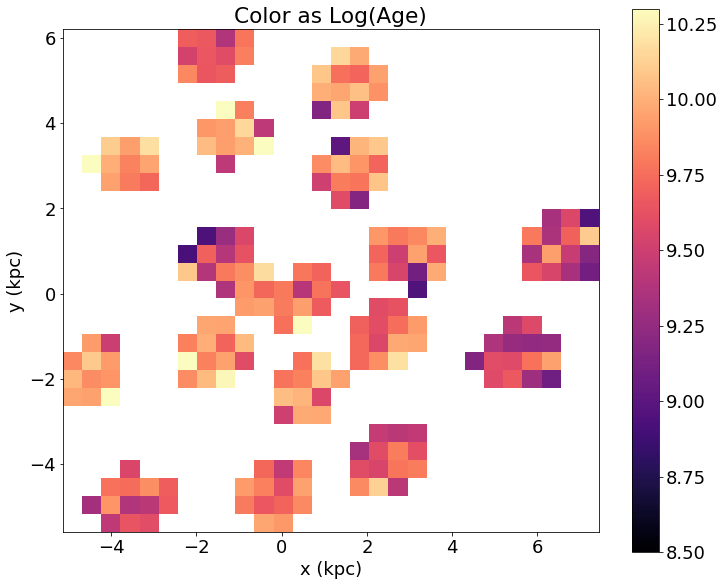

In [54]:
xlmc, ylmc, distlmc = afunc.LMCdisk_cart(r13['RA'],r13['DEC'])

H, xedges, yedges = np.histogram2d(xlmc,ylmc,bins=28,weights=parages)
H_o, xedges, yedges = np.histogram2d(xlmc,ylmc,bins=28)
# mask=H_o < 3
# H_o[mask] = np.nan

plt.figure(figsize=[12,10])
plt.imshow(H.T/H_o.T,interpolation='nearest',origin='lower', 
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],cmap='magma',vmin=8.5,vmax=10.3)
plt.colorbar()
plt.title(r'Color as Log(Age)')
plt.xlabel(r'x (kpc)')
plt.ylabel(r'y (kpc)')
# plt.savefig('age_map.pdf',bbox_inches='tight')

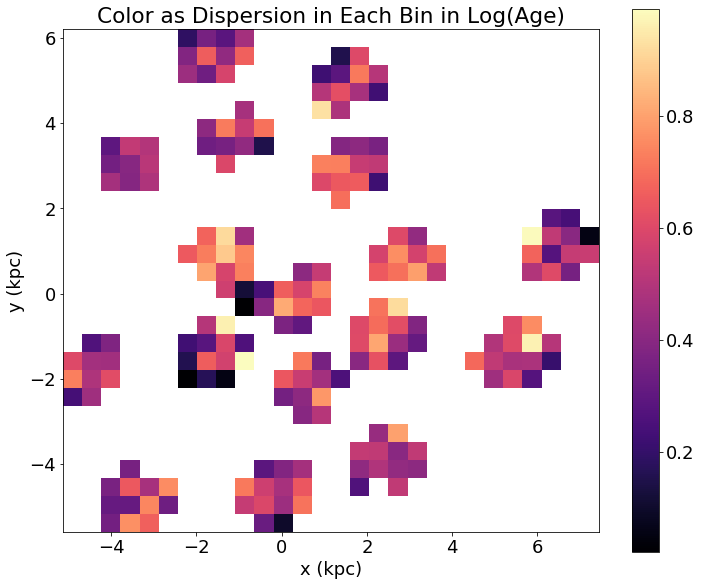

In [55]:
from scipy.stats import binned_statistic_2d

bin_stat, bin_x_edge, bin_y_edge, _ = binned_statistic_2d(xlmc, ylmc, parages, 'std', bins=28)

mask=bin_stat <= 0.
bin_stat[mask] = np.nan

plt.figure(figsize=[12,10])
plt.imshow(bin_stat.T,interpolation='nearest',origin='lower', 
           extent=[bin_x_edge[0], bin_x_edge[-1], bin_y_edge[0], bin_y_edge[-1]],cmap='magma')
plt.colorbar()
plt.title(r'Color as Dispersion in Each Bin in Log(Age)')
plt.xlabel(r'x (kpc)')
plt.ylabel(r'y (kpc)')
# plt.savefig('age_disper_map.pdf',bbox_inches='tight')
plt.show()